# Mạng nơ-ron

Mạng nơ-ron được xây dựng dựa trên ý tưởng mô phỏng lại cách hoạt động của bộ não con người. 
- Mỗi nơ-ron nhận tín hiệu truyền vào, xử lý tín hiệu và tiếp tục gửi tín hiệu đến nơ-ron kế tiếp cho đến khi tín hiệu được xử lý hoàn tất (forward). 
- Sau đó, thông tin về việc xử lý tín hiệu được truyền ngược lại thông qua một cung phản xạ đến nơ-ron phát tín hiệu ban đầu (backward).

Một mạng nơ-ron bắt buộc phải có một tầng đầu vào và một tầng đầu ra. Các tầng ẩn có thể có hoặc không.

<img src="multi_layers.png" style="width:50%; text-align:center">

Trên đây là một hình vẽ mô tả mạng nơ-ron đầy đủ với tầng đầu vào (`input`), 2 tầng ẩn (`hidden layer`) và tầng đầu ra (`output`). `W` là các trọng số dùng để biến đổi tín hiệu truyền từ nơ-ron này sang nơ-ron khác (hay từ lớp này sang lớp khác).

Trong bài học này, chúng ta sẽ làm quen với cách xây dựng một mô hình mạng nơ-ron nhân tạo sử dụng thư viện **Keras**.

In [2]:
# Import một số thư viện cần thiết.
import random
import numpy as np
import matplotlib.pyplot as plt
import keras

# Sử dụng một mẹo nhỏ để vẽ hình trên cùng một dòng thay vì mở cửa sổ mới
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # đặt kích thước mặc định cho hình
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Một mẹo nhỏ để notebook tự load lại các module bên ngoài;
# xem thêm tại http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [3]:
# Tải dữ liệu Cifar10 từ Keras và chia thành dữ liệu huấn luyện và kiểm tra.
from keras.datasets import cifar10

# Dữ liệu CIFAR10 gồm 50,000 ảnh màu kích thước 32x32 để huấn luyện, gồm 10 chuyên mục, và 10,000 ảnh kiểm tra.
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

140828672/170498071 [=======================>......] - ETA: 8s

170500096/170498071 [==============================] - 51s 0us/step
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


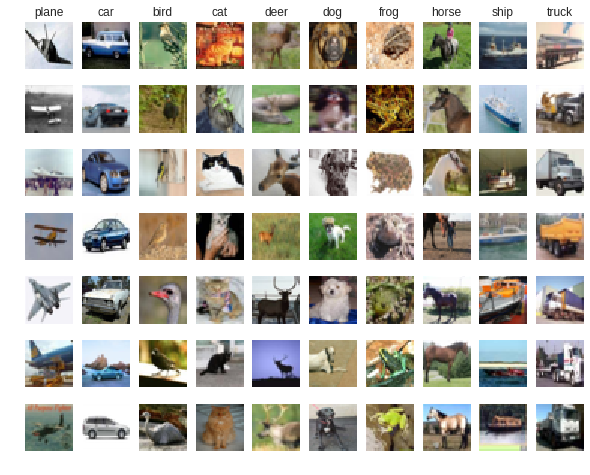

In [4]:
# Hiển thị một số ảnh từ trong bộ dữ liệu.
# Với mỗi lớp, chúng ta sẽ hiển thị một số ảnh minh họa.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [0]:
# Lấy 1 phần nhỏ dữ liệu để huấn luyện hiệu quả hơn trong bài tập này
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [6]:
# # Định dạng lại hình ảnh thành các hàng
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


# Xây dựng mô hình với Keras

**Keras** là một API mạng nơ-ron bậc cao, viết bằng ngôn ngữ Python và có thể chạy trên nền của `Tensorflow`, `CNTK` hay `Theano`.  `Keras` được phát triển với trọng tâm là cho phép người phát triển xây dựng những thử nghiệm nhanh chóng, đi từ ý tưởng đến kết quả với ít chậm trễ nhất.

Cấu trúc dữ liệu cốt lõi của **Keras** là mô hình, cách để tổ chức các lớp. 

Để xây dựng một mô hình trong **Keras**, ta có 2 cách:
- Xây dụng mô hình tuần tự (Sequential model) *hoặc*
- Xây dựng API chức năng (Functional API)

## Mô hình tuần tự
**Mô hình tuần tự** là loại mô hình đơn giản nhất trong **Keras**, là một ngăn xếp tuyến tính các lớp. Để xây dựng mô hình tuần tự, ta thêm lần lượt các lớp theo thứ tự vào trong mô hình.

In [0]:
# import mô hình tuần tự từ thư viện Keras
from keras.models import Sequential

# khởi tạo biến model là một ngăn xếp chứa các lớp
model = Sequential()

### Dense
**Dense** được sử dụng để cài đặt biểu thức **output = activation(dot(input, kernel) + bias)**

Trong đó:
- **activation** là hàm kích hoạt trong một nơ-ron (một lớp), được truyền qua tham số **activation**;
- **kernel** là ma trận trọng số của từng lớp;
- **bias** là véc-tơ sai số của từng lớp.

Tìm hiểu thêm về **Dense** tại [đây](https://keras.io/layers/core/#dense)

In [0]:
# import Dense để tạo ra các lớp trong ngăn xếp model
from keras.layers import Dense

# sử dụng hàm add() để thêm lớp vào trong ngăn xếp
# Tham số:
#    - input_shape hay input_dim: thể hiện kích thước hay số chiều của dữ liệu đầu vào
#    - units: số chiều của dữ liệu tại đầu ra của lớp hiện thời
#    - activation (optional): hàm kích hoạt được sử dụng trong lớp (mặc định là hàm tuyến tính: a(x) = x)

# lấy kích thước của dữ liệu đầu vào
# input_dim: số chiều của mỗi dữ liệu
input_dim = X_train.shape[1]

# input_shape gồm số lượng dữ liệu và số chiều của mỗi dữ liệu
input_shape = X_train.shape

# lớp đầu vào có đầu ra dữ liệu là 64 và không sử dụng hàm kích hoạt
model.add(Dense(units=1024, input_dim=input_dim))

### Hàm kích hoạt (Activation)
**Hàm kích hoạt** được sử dụng để biến đổi tín hiệu đầu vào của một nơ-ron thành tín hiệu đầu ra phù hợp để tiếp tục truyền đi đến nơ-ron tiếp theo.

Ta có thể truyền hàm kích hoạt vào trong mô hình như một tham số của lớp **Dense** hoặc truyền riêng biệt sử dụng lớp **Activation**.

Một số hàm kích hoạt thường sử dụng trong `Keras`: `sigmoid`, `softmax`, `tanh`, `relu`, `softplus`. Tìm hiểu thêm về các hàm kích hoạt tại [đây](https://keras.io/activations/)

In [0]:
# import lớp Activation
from keras.layers import Activation

# sử dụng hàm add() để thêm lớp Activation vào mô hình 
# (trước đó tầng ẩn đã được thêm vào với hàm model.add(Dense()))
# hàm kích hoạt được sử dụng là sigmoid
model.add(Activation('sigmoid'))

**Bài tập: ** Cài đặt thêm hai tẩng ẩn và tầng đầu ra vào mô hình với:
- Tầng thứ nhất: số chiều đầu ra là **512** và sử dụng hàm kích hoạt **tanh**;
- Tầng thứ hai: số chiều đầu ra là **128** và sử dụng hàm kích hoạt **relu**.
- Tầng đầu ra: số chiều đầu ra là **1**.

In [0]:
model.add(Dense(units=512, input_dim=1024))
model.add(Activation('tanh'))
model.add(Dense(units=128, input_dim=512))
model.add(Activation('relu'))
model.add(Dense(units=1, input_dim=128))

### Biên dịch
Sau khi xây dựng được cấu trúc các lớp trong ngăn xếp, ta cần chỉ ra quá trình học của mô hình thông qua hàm **compile()** trước khi huấn luyện mô hình.

Hàm này nhận 3 tham số quan trọng:
- Bộ tối ưu hóa (**optimizer**). Là một chuỗi xác định bộ tối ưu hóa đã được cài đặt sẵn (chẳng hạn như `rmsprop` hay `adam`) hay một thể hiện của lớp [**Optimizer**](https://keras.io/optimizers/). 
- Hàm mất mát (**loss**). Đây là đối tượng mô hình cần cực tiểu hóa. Nó là một xâu xác định tên hàm mất mát đã được cài đặt (ví dụ `categorical_crossentropy ` hay `mse`), hoặc một đối tượng hàm, chi tiết xem tại [đây.](https://keras.io/losses/)
- Danh sách metric (**metrics**). Trong bài toán phân lớp, ta thường chọn `metrics=['accuracy']`.

Tham khảo thêm tại [đây](https://keras.io/getting-started/sequential-model-guide/#compilation)

In [0]:
# Ví dụ về việc định nghĩa quá trình học của mô hình với
# bộ tối ưu là 'rmsprop', hàm mất mát là 'mse' (mean square error)
# và list metric là 'accuracy' 
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['accuracy'])

**Bài tập:** Biên dịch lại mô hình với hàm mất mát là **hinge**, tối ưu hóa bởi **adam** và trả về danh sách metrics **accuracy**.

In [0]:
model.compile(optimizer='adam',
              loss='hinge',
              metrics=['accuracy'])

### Huấn luyện mô hình
Các mô hình của **Keras** được huấn luyện trên các mảng **Numpy** của dữ liệu đầu vào và nhãn. Để huấn luyện một mô hình, cần sử dụng hàm **fit()**.

Một số tham số quan trọng của hàm **fit()**:
- **x**: Ddữ liệu huấn luyện dưới dạng mảng numpy;
- **y**: Nhãn dữ liệu tương ứng với dữ liệu huấn luyện (mảng numpy);
- **batch_size**: Số lượng dữ liệu trong mỗi lần cập nhật gradient (kiểu nguyên hoặc `None`). Giá trị mặc định là `32`.
- **epochs**: Số lượng giai đoạn để huấn luyện mô hình (kiểu nguyên).

Tìm hiểu thêm về các hàm liên quan tại [đây](https://keras.io/models/sequential/)

In [17]:
# Huấn luyện mô hình dựa trên dữ liệu huấn luyện X_train, y_train
# Lặp lại quá trình học với epochs=10 và batch_size=32
history = model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.1249 - acc: 8.0000e-04
Epoch 2/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 3/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 4/10
 224/5000 [>.............................] - ETA: 10s - loss: 0.1384 - acc: 0.0000e+00

5000/5000 [==============================] - 11s 2ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 5/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 6/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 7/10
 544/5000 [==>...........................] - ETA: 9s - loss: 0.1066 - acc: 0.0000e+00

5000/5000 [==============================] - 11s 2ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 8/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 9/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 10/10
 416/5000 [=>............................] - ETA: 9s - loss: 0.0986 - acc: 0.0000e+00

5000/5000 [==============================] - 11s 2ms/step - loss: 0.1010 - acc: 0.0000e+00


Hàm **fit()** trả về **History** lưu lại lịch sử cập nhật của mô hình. Ta có thể vẽ lại được sự thay đổi của mô hình dựa trên thuộc tính **History.history**, nó lưu lại các giá trị hàm mất mát (`loss`) và giá trị metric tương ứng (`acc`) qua mỗi giai đoạn.

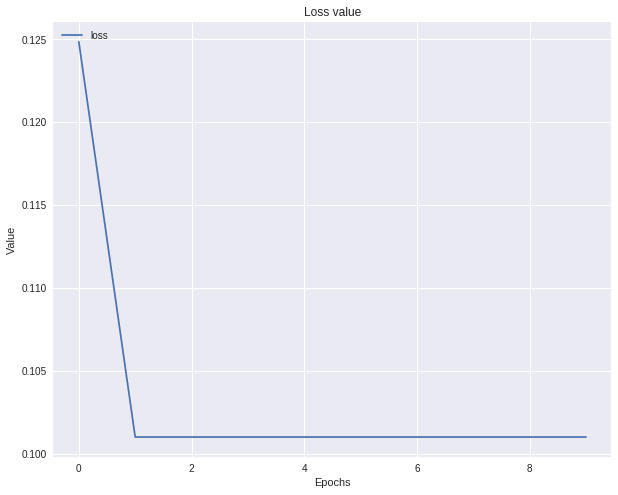

In [21]:
# Xây dựng biểu đồ thể hiện lịch sử thay đổi của mô hình qua mỗi giai đoạn
def draw(history):
  plt.plot(history.history['loss'])
  plt.title("Loss value")
  plt.xlabel("Epochs")
  plt.ylabel("Value")
  plt.legend(['loss'], loc='upper left')
  plt.show()
 
draw(history)

 
**Bài tập:** Huấn luyện lại mô hình với số epochs là **100** và batch_size bằng **64**. Sử dụng một biến để lưu lại giá trị trả về của hàm **fit()**, dựa vào đó, vẽ lại biểu đồ sự thay đổi của metric qua các giai đoạn.  

Epoch 1/100
5000/5000 [==============================] - 5s 904us/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 2/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 3/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 4/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 5/100
2624/5000 [==============>...............] - ETA: 2s - loss: 0.1021 - acc: 0.0000e+00

5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 6/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 7/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 8/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 9/100
3520/5000 [====================>.........] - ETA: 1s - loss: 0.1043 - acc: 0.0000e+00

5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 10/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 11/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 12/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 13/100
3520/5000 [====================>.........] - ETA: 1s - loss: 0.1017 - acc: 0.0000e+00

5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 14/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 15/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 16/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 17/100
3520/5000 [====================>.........] - ETA: 1s - loss: 0.1006 - acc: 0.0000e+00

5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 18/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 19/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 20/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 21/100
3584/5000 [====================>.........] - ETA: 1s - loss: 0.0963 - acc: 0.0000e+00

5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 22/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 23/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 24/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 25/100
3520/5000 [====================>.........] - ETA: 1s - loss: 0.1054 - acc: 0.0000e+00

5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 26/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 27/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 28/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 29/100
3520/5000 [====================>.........] - ETA: 1s - loss: 0.1011 - acc: 0.0000e+00

5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 30/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 31/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 32/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 33/100
3648/5000 [====================>.........] - ETA: 1s - loss: 0.1012 - acc: 0.0000e+00

5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 34/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 35/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 36/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 37/100
3584/5000 [====================>.........] - ETA: 1s - loss: 0.0999 - acc: 0.0000e+00

5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 38/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 39/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 40/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 41/100
3584/5000 [====================>.........] - ETA: 1s - loss: 0.1038 - acc: 0.0000e+00

5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 42/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 43/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 44/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 45/100
3584/5000 [====================>.........] - ETA: 1s - loss: 0.1052 - acc: 0.0000e+00

5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 46/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 47/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 48/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 49/100
3584/5000 [====================>.........] - ETA: 1s - loss: 0.1016 - acc: 0.0000e+00

5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 50/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 51/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 52/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 53/100
3584/5000 [====================>.........] - ETA: 1s - loss: 0.1057 - acc: 0.0000e+00

5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 54/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 55/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 56/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 57/100
3520/5000 [====================>.........] - ETA: 1s - loss: 0.0960 - acc: 0.0000e+00

5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 58/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 59/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 60/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 61/100
3520/5000 [====================>.........] - ETA: 1s - loss: 0.0957 - acc: 0.0000e+00

5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 62/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 63/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 64/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 65/100
3584/5000 [====================>.........] - ETA: 1s - loss: 0.1013 - acc: 0.0000e+00

5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 66/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 67/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 68/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 69/100
3584/5000 [====================>.........] - ETA: 1s - loss: 0.1024 - acc: 0.0000e+00

5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 70/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 71/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 72/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 73/100
3584/5000 [====================>.........] - ETA: 1s - loss: 0.1010 - acc: 0.0000e+00

5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 74/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 75/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 76/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 77/100
3584/5000 [====================>.........] - ETA: 1s - loss: 0.1016 - acc: 0.0000e+00

5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 78/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 79/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 80/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 81/100
3584/5000 [====================>.........] - ETA: 1s - loss: 0.1016 - acc: 0.0000e+00

5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 82/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 83/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 84/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 85/100
3520/5000 [====================>.........] - ETA: 1s - loss: 0.0960 - acc: 0.0000e+00

5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 86/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 87/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 88/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 89/100
3584/5000 [====================>.........] - ETA: 1s - loss: 0.0988 - acc: 0.0000e+00

5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 90/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 91/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 92/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 93/100
3584/5000 [====================>.........] - ETA: 1s - loss: 0.1063 - acc: 0.0000e+00

5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 94/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 95/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 96/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 97/100
3584/5000 [====================>.........] - ETA: 1s - loss: 0.1046 - acc: 0.0000e+00

5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 98/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 99/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00
Epoch 100/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1010 - acc: 0.0000e+00


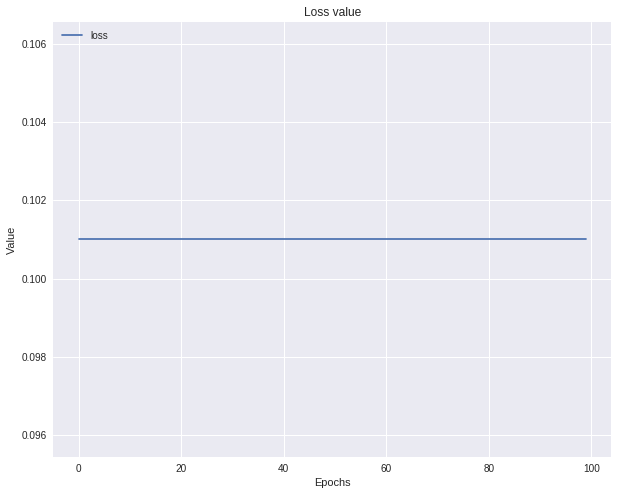

In [22]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64)
draw(history)

### Dự đoán

Sau khi huấn luyện, mô hình được đánh giá với dữ liệu kiểm tra bằng hàm **evaluate()**.

Hàm nhận 3 tham số quan trọng lần lượt là:
- **x**: Dữ liệu kiểm tra (kiểu mảng Numpy);
- **y**: Nhãn tương ứng với dữ liệu kiểm tra (kiểu mảng Numpy);
- **batch_size**: Số lượng ví dụ được dùng trong mỗi lần cập nhật gradient (kiểu nguyên). Mặc định là **32**.

Hàm trả về một mảng số thực **score** chứa giá trị hàm mất mát (**loss**) và giá trị metric (**accuracy**). Nếu mô hình không có metric, **score** là giá trị mất mát.

In [24]:
score = model.evaluate(X_test, y_test, batch_size=16)
print(score)

500/500 [==============================] - 0s 516us/step
[0.114, 0.0]


## API chức năng
**API chức năng** là lựa chọn tối ưu trong việc xây dựng mạng kết nối với mật độ cao (các lớp không liên kết tuần tự trong ngăn xếp).

Các lớp có thể đồng thời là đầu vào của nhiều lớp kế tiếp, bằng cách sử dụng đầu ra của lớp đó như một tham số truyền vào của một hàm của lớp khác.

Xây dựng một mô hình với **API chức năng** về cơ bản giống với xây dựng **mô hình tuần tự**. Điều khác nhau duy nhất là quá trình xây dựng cấu trúc các lớp.

In [0]:
# import thêm lớp Input để khởi tạo mô hình
from keras.layers import Input
from keras.models import Model

# khởi tạo một thể hiện của lớp Input
# tham số shape (kiểu tuple) là kích thước của dữ liệu đầu vào (số chiều dữ liệu)
# giá trị trả về là một tensor
input_dim = X_train.shape[1]
inputs = Input(shape=(input_dim,))

# mỗi thể hiện của một lớp có thể được gọi bởi một tensor
# và kết quả trả về là một tensor
# thêm một tầng ẩn gọi đến tensor inputs
x = Dense(64, activation="sigmoid")(inputs)

# ... có thể thêm nhiều tầng ẩn ở giữa ...

# tầng đầu ra của mô hình với số chiều 1
predictions = Dense(1)(x)

# Tạo ra mô hình mới bao gồm tầng đầu vào và các tầng ẩn (kết thúc bằng tensor predictions)
api_model = Model(inputs=inputs, outputs=predictions)

Phần còn lại của quá trình xây dựng **API chức năng** tương tự như **Mô hình tuần tự**.

Tham khảo thêm tại [đây](https://keras.io/getting-started/functional-api-guide/)

**Bài tập:** Tiếp tục hoàn thiện quá trình xây dụng **API chức năng** (biên dịch và huấn luyện mô hình). Sử dụng kết quả **History** trong quá trình huấn luyện để vẽ ra đồ thị thay đổi của giá trị mất mát trong các giai đoạn.

Epoch 1/50
5000/5000 [==============================] - 1s 136us/step - loss: 8.3525 - acc: 0.0998
Epoch 2/50
5000/5000 [==============================] - 1s 107us/step - loss: 8.2294 - acc: 0.0998
Epoch 3/50
5000/5000 [==============================] - 1s 111us/step - loss: 8.2258 - acc: 0.1018
Epoch 4/50
5000/5000 [==============================] - 1s 109us/step - loss: 8.2386 - acc: 0.1028
Epoch 5/50
5000/5000 [==============================] - 0s 92us/step - loss: 8.2306 - acc: 0.1050
Epoch 6/50
5000/5000 [==============================] - 0s 91us/step - loss: 8.2319 - acc: 0.0986
Epoch 7/50
5000/5000 [==============================] - 0s 93us/step - loss: 8.2307 - acc: 0.0996
Epoch 8/50
5000/5000 [==============================] - 0s 97us/step - loss: 8.2323 - acc: 0.1026
Epoch 9/50
5000/5000 [==============================] - 0s 95us/step - loss: 8.2309 - acc: 0.0928
Epoch 10/50
5000/5000 [==============================] - 0s 94us/step - loss: 8.2246 - acc: 0.1032
Epoch 11/50
500

5000/5000 [==============================] - 0s 97us/step - loss: 8.2301 - acc: 0.0976
Epoch 15/50
5000/5000 [==============================] - 0s 90us/step - loss: 8.2286 - acc: 0.0990
Epoch 16/50
5000/5000 [==============================] - 0s 91us/step - loss: 8.2273 - acc: 0.1012
Epoch 17/50
5000/5000 [==============================] - 0s 89us/step - loss: 8.2349 - acc: 0.1016
Epoch 18/50
5000/5000 [==============================] - 0s 96us/step - loss: 8.2343 - acc: 0.0950
Epoch 19/50
5000/5000 [==============================] - 0s 91us/step - loss: 8.2262 - acc: 0.0976
Epoch 20/50
5000/5000 [==============================] - 0s 93us/step - loss: 8.2316 - acc: 0.1042
Epoch 21/50
5000/5000 [==============================] - 0s 91us/step - loss: 8.2293 - acc: 0.1032
Epoch 22/50
5000/5000 [==============================] - 0s 92us/step - loss: 8.2235 - acc: 0.0950
Epoch 23/50
5000/5000 [==============================] - 0s 92us/step - loss: 8.2336 - acc: 0.1014
Epoch 24/50
5000/5000 

5000/5000 [==============================] - 0s 91us/step - loss: 8.2322 - acc: 0.1026
Epoch 28/50
5000/5000 [==============================] - 0s 87us/step - loss: 8.2351 - acc: 0.0988
Epoch 29/50
5000/5000 [==============================] - 0s 93us/step - loss: 8.2225 - acc: 0.0974
Epoch 30/50
5000/5000 [==============================] - 0s 95us/step - loss: 8.2295 - acc: 0.1032
Epoch 31/50
5000/5000 [==============================] - 0s 91us/step - loss: 8.2268 - acc: 0.1030
Epoch 32/50
5000/5000 [==============================] - 0s 94us/step - loss: 8.2252 - acc: 0.0958
Epoch 33/50
5000/5000 [==============================] - 0s 91us/step - loss: 8.2354 - acc: 0.0964
Epoch 34/50
5000/5000 [==============================] - 0s 90us/step - loss: 8.2299 - acc: 0.1040
Epoch 35/50
5000/5000 [==============================] - 0s 92us/step - loss: 8.2278 - acc: 0.1000
Epoch 36/50
5000/5000 [==============================] - 0s 93us/step - loss: 8.2247 - acc: 0.1024
Epoch 37/50
5000/5000 

5000/5000 [==============================] - 0s 94us/step - loss: 8.2285 - acc: 0.0960
Epoch 41/50
5000/5000 [==============================] - 0s 89us/step - loss: 8.2297 - acc: 0.0986
Epoch 42/50
5000/5000 [==============================] - 0s 92us/step - loss: 8.2367 - acc: 0.0954
Epoch 43/50
5000/5000 [==============================] - 0s 91us/step - loss: 8.2275 - acc: 0.0972
Epoch 44/50
5000/5000 [==============================] - 0s 92us/step - loss: 8.2294 - acc: 0.0938
Epoch 45/50
5000/5000 [==============================] - 0s 94us/step - loss: 8.2263 - acc: 0.0990
Epoch 46/50
5000/5000 [==============================] - 0s 91us/step - loss: 8.2248 - acc: 0.0964
Epoch 47/50
5000/5000 [==============================] - 0s 89us/step - loss: 8.2254 - acc: 0.0980
Epoch 48/50
5000/5000 [==============================] - 0s 91us/step - loss: 8.2290 - acc: 0.0980
Epoch 49/50
5000/5000 [==============================] - 0s 84us/step - loss: 8.2275 - acc: 0.1028
Epoch 50/50
5000/5000 

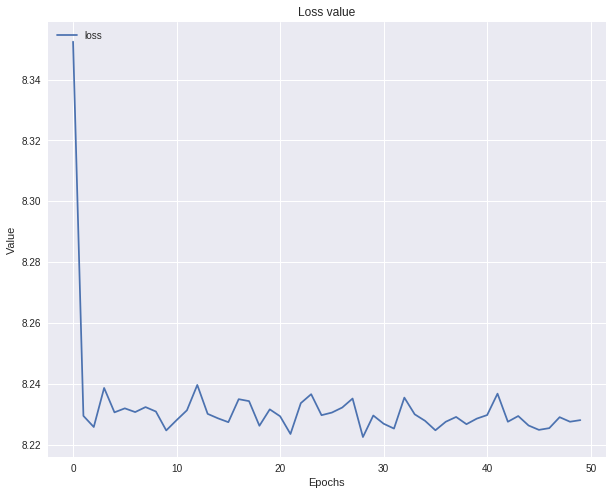

In [26]:
api_model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])
history = api_model.fit(X_train, y_train, epochs=50, batch_size=64)
draw(history)

In [27]:
score = model.evaluate(X_test, y_test, batch_size=16)
print(score)

500/500 [==============================] - 0s 328us/step
[0.114, 0.0]


### Bài tập
Xây dựng mô hình (bằng **API chức năng** hoặc **Mô hình tuần tự**) sao cho hiệu năng (`acc`) trên tập kiểm tra đạt trên 15%.

In [28]:
from keras.layers import BatchNormalization, Dropout, Input
from keras.models import Model
import keras
inputs = Input(shape=(input_dim, ))
x = Dense(64, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

early_stoping = keras.callbacks.EarlyStopping(patience=30, verbose=1)
save_model = keras.callbacks.ModelCheckpoint('best.hdf5', save_best_only=True)
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stoping, save_model])

Train on 4000 samples, validate on 1000 samples
Epoch 1/100
4000/4000 [==============================] - 4s 909us/step - loss: 25.3495 - acc: 0.0635 - val_loss: 26.1953 - val_acc: 0.0670
Epoch 2/100
4000/4000 [==============================] - 2s 623us/step - loss: 16.2509 - acc: 0.0912 - val_loss: 98.6814 - val_acc: 0.1090
Epoch 3/100
4000/4000 [==============================] - 3s 634us/step - loss: 9.4427 - acc: 0.1175 - val_loss: 153.8329 - val_acc: 0.0980
Epoch 4/100
4000/4000 [==============================] - 2s 621us/step - loss: 6.8126 - acc: 0.1188 - val_loss: 39.7964 - val_acc: 0.1130
Epoch 5/100
4000/4000 [==============================] - 2s 622us/step - loss: 6.0984 - acc: 0.1465 - val_loss: 20.5106 - val_acc: 0.1440
Epoch 6/100
4000/4000 [==============================] - 2s 624us/step - loss: 5.7051 - acc: 0.1593 - val_loss: 32.5251 - val_acc: 0.1260
Epoch 7/100
 576/4000 [===>..........................] - ETA: 2s - loss: 4.8143 - acc: 0.1632

4000/4000 [==============================] - 3s 628us/step - loss: 5.2603 - acc: 0.1685 - val_loss: 28.9443 - val_acc: 0.1610
Epoch 8/100
4000/4000 [==============================] - 2s 621us/step - loss: 4.6447 - acc: 0.1905 - val_loss: 29.6937 - val_acc: 0.1330
Epoch 9/100
4000/4000 [==============================] - 2s 624us/step - loss: 4.4646 - acc: 0.1970 - val_loss: 169.6354 - val_acc: 0.1310
Epoch 10/100
4000/4000 [==============================] - 3s 627us/step - loss: 4.0366 - acc: 0.1992 - val_loss: 339.2365 - val_acc: 0.1440
Epoch 11/100
4000/4000 [==============================] - 2s 625us/step - loss: 3.7386 - acc: 0.2233 - val_loss: 74.2887 - val_acc: 0.1440
Epoch 12/100
4000/4000 [==============================] - 3s 629us/step - loss: 3.3614 - acc: 0.2340 - val_loss: 721.9334 - val_acc: 0.1290
Epoch 13/100
2368/4000 [================>.............] - ETA: 0s - loss: 3.0217 - acc: 0.2500

4000/4000 [==============================] - 2s 625us/step - loss: 3.0581 - acc: 0.2445 - val_loss: 61.5831 - val_acc: 0.1630
Epoch 14/100
4000/4000 [==============================] - 3s 630us/step - loss: 2.9706 - acc: 0.2717 - val_loss: 25.3449 - val_acc: 0.1380
Epoch 15/100
4000/4000 [==============================] - 2s 623us/step - loss: 2.6758 - acc: 0.2722 - val_loss: 63.6493 - val_acc: 0.1410
Epoch 16/100
4000/4000 [==============================] - 2s 619us/step - loss: 2.3487 - acc: 0.2950 - val_loss: 108.9499 - val_acc: 0.1620
Epoch 17/100
4000/4000 [==============================] - 3s 626us/step - loss: 2.1282 - acc: 0.3088 - val_loss: 22.7454 - val_acc: 0.1510
Epoch 18/100
4000/4000 [==============================] - 2s 621us/step - loss: 2.0482 - acc: 0.3083 - val_loss: 35.2383 - val_acc: 0.1360
Epoch 19/100
2368/4000 [================>.............] - ETA: 0s - loss: 2.0047 - acc: 0.3142

4000/4000 [==============================] - 3s 629us/step - loss: 2.1223 - acc: 0.3105 - val_loss: 70.9647 - val_acc: 0.1460
Epoch 20/100
4000/4000 [==============================] - 2s 623us/step - loss: 1.9659 - acc: 0.3197 - val_loss: 209.2102 - val_acc: 0.1550
Epoch 21/100
4000/4000 [==============================] - 2s 625us/step - loss: 1.6970 - acc: 0.3278 - val_loss: 199.8811 - val_acc: 0.1500
Epoch 22/100
4000/4000 [==============================] - 2s 616us/step - loss: 1.5608 - acc: 0.3505 - val_loss: 123.0557 - val_acc: 0.1550
Epoch 23/100
4000/4000 [==============================] - 2s 622us/step - loss: 1.4273 - acc: 0.3665 - val_loss: 637.3544 - val_acc: 0.1570
Epoch 24/100
4000/4000 [==============================] - 3s 627us/step - loss: 1.3395 - acc: 0.3795 - val_loss: 15.4459 - val_acc: 0.1570
Epoch 25/100
2496/4000 [=================>............] - ETA: 0s - loss: 1.1885 - acc: 0.3822

4000/4000 [==============================] - 3s 626us/step - loss: 1.1820 - acc: 0.3843 - val_loss: 11.6211 - val_acc: 0.1610
Epoch 26/100
4000/4000 [==============================] - 2s 616us/step - loss: 1.3099 - acc: 0.3897 - val_loss: 30.1009 - val_acc: 0.1630
Epoch 27/100
4000/4000 [==============================] - 3s 634us/step - loss: 1.1447 - acc: 0.3977 - val_loss: 60.6567 - val_acc: 0.1750
Epoch 28/100
4000/4000 [==============================] - 2s 622us/step - loss: 1.1909 - acc: 0.3997 - val_loss: 1126.0793 - val_acc: 0.1520
Epoch 29/100
4000/4000 [==============================] - 2s 616us/step - loss: 1.1608 - acc: 0.4065 - val_loss: 1068.8774 - val_acc: 0.1000
Epoch 30/100
4000/4000 [==============================] - 3s 626us/step - loss: 1.0560 - acc: 0.4195 - val_loss: 405.9887 - val_acc: 0.1550
Epoch 31/100
2496/4000 [=================>............] - ETA: 0s - loss: 1.0510 - acc: 0.4062

4000/4000 [==============================] - 3s 626us/step - loss: 1.0381 - acc: 0.4062 - val_loss: 211.1245 - val_acc: 0.1730
Epoch 32/100
4000/4000 [==============================] - 3s 625us/step - loss: 1.0267 - acc: 0.4218 - val_loss: 403.9565 - val_acc: 0.1500
Epoch 33/100
4000/4000 [==============================] - 2s 621us/step - loss: 1.0309 - acc: 0.4228 - val_loss: 284.8222 - val_acc: 0.1650
Epoch 34/100
4000/4000 [==============================] - 2s 619us/step - loss: 1.0028 - acc: 0.4333 - val_loss: 190.4624 - val_acc: 0.1710
Epoch 35/100
4000/4000 [==============================] - 3s 626us/step - loss: 0.8333 - acc: 0.4557 - val_loss: 13.1537 - val_acc: 0.1810
Epoch 36/100
4000/4000 [==============================] - 3s 625us/step - loss: 0.8193 - acc: 0.4720 - val_loss: 13.2450 - val_acc: 0.1420
Epoch 37/100
2112/4000 [==============>...............] - ETA: 1s - loss: 0.8630 - acc: 0.4877

4000/4000 [==============================] - 3s 634us/step - loss: 0.9015 - acc: 0.4688 - val_loss: 24.5754 - val_acc: 0.1480
Epoch 38/100
4000/4000 [==============================] - 2s 623us/step - loss: 0.8243 - acc: 0.4627 - val_loss: 71.9542 - val_acc: 0.1490
Epoch 39/100
4000/4000 [==============================] - 3s 630us/step - loss: 0.9291 - acc: 0.4552 - val_loss: 10.6144 - val_acc: 0.1540
Epoch 40/100
4000/4000 [==============================] - 2s 621us/step - loss: 1.0627 - acc: 0.4393 - val_loss: 21.0844 - val_acc: 0.1450
Epoch 41/100
4000/4000 [==============================] - 2s 624us/step - loss: 0.9445 - acc: 0.4492 - val_loss: 13.0365 - val_acc: 0.1540
Epoch 42/100
4000/4000 [==============================] - 3s 627us/step - loss: 0.8696 - acc: 0.4480 - val_loss: 92.2141 - val_acc: 0.1600
Epoch 43/100
2368/4000 [================>.............] - ETA: 0s - loss: 0.6440 - acc: 0.5342

4000/4000 [==============================] - 3s 633us/step - loss: 0.6527 - acc: 0.5170 - val_loss: 45.5619 - val_acc: 0.1600
Epoch 44/100
4000/4000 [==============================] - 2s 625us/step - loss: 0.7193 - acc: 0.5145 - val_loss: 544.7693 - val_acc: 0.1590
Epoch 45/100
4000/4000 [==============================] - 2s 620us/step - loss: 0.7228 - acc: 0.4920 - val_loss: 17.9436 - val_acc: 0.1580
Epoch 46/100
4000/4000 [==============================] - 2s 622us/step - loss: 0.6404 - acc: 0.5005 - val_loss: 22.4458 - val_acc: 0.1700
Epoch 47/100
4000/4000 [==============================] - 2s 623us/step - loss: 0.5983 - acc: 0.5325 - val_loss: 37.2362 - val_acc: 0.1980
Epoch 48/100
4000/4000 [==============================] - 2s 621us/step - loss: 0.5940 - acc: 0.5330 - val_loss: 15.6532 - val_acc: 0.1940
Epoch 49/100
2368/4000 [================>.............] - ETA: 0s - loss: 0.6045 - acc: 0.5160

4000/4000 [==============================] - 3s 628us/step - loss: 0.6241 - acc: 0.5118 - val_loss: 45.4822 - val_acc: 0.1730
Epoch 50/100
4000/4000 [==============================] - 3s 629us/step - loss: 0.6681 - acc: 0.5140 - val_loss: 12.0914 - val_acc: 0.1560
Epoch 51/100
4000/4000 [==============================] - 3s 630us/step - loss: 0.6911 - acc: 0.5048 - val_loss: 33.8470 - val_acc: 0.1550
Epoch 52/100
4000/4000 [==============================] - 2s 623us/step - loss: 0.6966 - acc: 0.5145 - val_loss: 68.9912 - val_acc: 0.1480
Epoch 53/100
4000/4000 [==============================] - 2s 620us/step - loss: 0.6237 - acc: 0.5150 - val_loss: 57.8812 - val_acc: 0.1690
Epoch 54/100
4000/4000 [==============================] - 2s 618us/step - loss: 0.6858 - acc: 0.5178 - val_loss: 14.9204 - val_acc: 0.1940
Epoch 55/100
2240/4000 [===============>..............] - ETA: 1s - loss: 1.0931 - acc: 0.4674

4000/4000 [==============================] - 2s 610us/step - loss: 1.0997 - acc: 0.4565 - val_loss: 303.0924 - val_acc: 0.1380
Epoch 56/100
4000/4000 [==============================] - 2s 609us/step - loss: 0.9906 - acc: 0.4545 - val_loss: 17.5702 - val_acc: 0.1580
Epoch 57/100
4000/4000 [==============================] - 2s 613us/step - loss: 0.8977 - acc: 0.4705 - val_loss: 52.4858 - val_acc: 0.1560
Epoch 58/100
4000/4000 [==============================] - 2s 606us/step - loss: 0.9987 - acc: 0.4555 - val_loss: 163.2130 - val_acc: 0.1090
Epoch 59/100
4000/4000 [==============================] - 2s 615us/step - loss: 0.7679 - acc: 0.4710 - val_loss: 11.5080 - val_acc: 0.1570
Epoch 60/100
4000/4000 [==============================] - 3s 627us/step - loss: 0.6497 - acc: 0.5230 - val_loss: 13.8405 - val_acc: 0.1750
Epoch 61/100
2112/4000 [==============>...............] - ETA: 1s - loss: 0.7397 - acc: 0.4991

4000/4000 [==============================] - 3s 626us/step - loss: 0.7160 - acc: 0.5042 - val_loss: 303.8419 - val_acc: 0.1940
Epoch 62/100
4000/4000 [==============================] - 2s 612us/step - loss: 0.7738 - acc: 0.4892 - val_loss: 435.3121 - val_acc: 0.1720
Epoch 63/100
4000/4000 [==============================] - 2s 608us/step - loss: 0.7250 - acc: 0.5060 - val_loss: 910.7600 - val_acc: 0.1820
Epoch 64/100
4000/4000 [==============================] - 2s 612us/step - loss: 0.5680 - acc: 0.5460 - val_loss: 282.8533 - val_acc: 0.1870
Epoch 65/100
4000/4000 [==============================] - 2s 614us/step - loss: 0.5214 - acc: 0.5580 - val_loss: 185.6886 - val_acc: 0.1670
Epoch 66/100
4000/4000 [==============================] - 2s 615us/step - loss: 0.5428 - acc: 0.5493 - val_loss: 101.4338 - val_acc: 0.1690
Epoch 67/100
1984/4000 [=============>................] - ETA: 1s - loss: 0.4339 - acc: 0.5897

4000/4000 [==============================] - 2s 605us/step - loss: 0.4539 - acc: 0.5793 - val_loss: 434.1011 - val_acc: 0.1480
Epoch 68/100
4000/4000 [==============================] - 2s 613us/step - loss: 0.5958 - acc: 0.5570 - val_loss: 370.2664 - val_acc: 0.1450
Epoch 69/100
4000/4000 [==============================] - 2s 608us/step - loss: 0.6140 - acc: 0.5215 - val_loss: 382.5759 - val_acc: 0.1620
Epoch 00069: early stopping


In [29]:
model.load_weights('best.hdf5')
model.evaluate(X_test, y_test)

500/500 [==============================] - 0s 221us/step


[10.208122573852538, 0.12800000002980233]